In [1]:
# import general libraries
import os
%load_ext autoreload
%autoreload 2

# import graphics libraries
from tqdm import tqdm
from PIL import Image
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline

# import ML libraries
import torch.nn as nn
import torch.optim as optim

# import auxiliary libraries
from lib.dataset_creation import create_dataset
from lib.draw import plot_hist, plot_scatter
from lib.data_preparation import prepare_data
from lib.epoch import train_epoch, adjust_learning_rate

# style
from pathlib import Path
from IPython.core.display import HTML
style = open(str(Path.home())+'/.jupyter/custom/custom.css', "r").read()
HTML('<style>%s</style>' % style)

<h1>
    A Pytorch example on adversarial networks
</h1>

<div>
This example shows how, using adversarial training,
it is possible to make a neural network unsensitive
to systematic uncertainties that could affect your measurement.
The approach has been already demonstrated effective by
a paper published in 2016 (not by me, just to be clear). 
</div>
<br>
"Learning to pivot with adversarial networks",<br>
Gilles Louppe, Michael Kagan, Kyle Cranmer,<br>
2016-11-03,<br>
https://arxiv.org/abs/1611.01046

<div>
Systematic uncertainties can come from many sources. In image
processing, for example, the distance at which each picture has been
taken could constitute an important uncertainty to take into account.
</div>
<br>    
<div>
To make your model, and predictions, robust you can follow two approaches:
either you take all your pictures at the same distance (think at the 
airport face scanners, where they force you to stay in a certain spot),
or you include pictures taken at any possible distance. Take in mind that
this "any" could mean a lot. Alternatively, what you could also do 
is to force your network to learn exclusively features that are 
unsensitive to the distance at which the picture has been taken. 
You can do this by using adversarial networks.
</div>
<br>
Example of feature indipendent from the distance: number of teeth.<br>
Example of feature dependent from the distance: separation between eyes.

![title](images/smiles.jpg)

<div>
In more general terms, the following study shows how including 
systematic variations in the training is often not enough to
create a robust model, which in principle should be unsensitive 
wrt to such systematic errors. Adversarial training solves the problem: 
in such scenario a discriminant is trained to distinguish between the 
classes of interest, while an adversarial term learns to distinguish
between the nominal sample and the systematic variations based on the 
output of the first classifier.
</div>
<br>    
<div>
The two components are trained simultaneously using a loss function
that combines the losses of the two terms. In particular, the loss
of the adversarial term is multiplied by a (large) penalty and
subtracted from the loss of the discriminant so to give "positive"
points to a discriminant that can distinguish btw classes and
"negative" points to a discriminant that produces very different
distribution for the nominal sample and the systematic uncertainties.
</div>

<h2>
    Introduction to Neural Networks
</h2>

How does a standard neural network work?

![title](images/neural_net.jpg)

How does an adversarial neural network work (or at least the one used here)?

![title](images/neural_net1.jpg)

<h2>
    Introducing the example
</h2>

In [2]:
# where to save outputs
path = "output/"

try:
    os.stat(path)
except Exception:
    os.mkdir(path)

# feature name (i.e. the coordinates of the distributions)
features = ['x', 'y']

# how many samples are generated per class
n_samples = 30000

<div>
To prove our point, we are going to create a toy dataset composed of two classes:
</div>
    
<ul>
    <li> class 0: a 2d normal distribution with mean [0,0] and standard deviation [1,2];</li>
    <li> class 1: an annulus distribution of radius 2. </li>
</ul>

Two systematic variations are also made available for class 0:

<ul>
    <li> syst 1: a 2d normal distribution with mean [0,-2] and standard deviation [1,2];</li>
    <li> syst 2: a 2d normal distribution with mean [0,2] and standard deviation [1,2]. </li>
</ul>

<div>
The dataset will be saved as pandas dataframe with the following columns:
</div>
    
<ul>
    <li> x: x coordinate of the distribution;</li>
    <li> y: y coordinate of the distribution;</li>
    <li> class_idx: the index associated to the classes;</li>
    <li> class_name: class name (gaus, gaus_s1, gaus_s2, annulus);</li>
    <li> class_color: color to be used in the plots for this class;</li>
    <li> syst_idx: the index associated to the systematic variations;</li>
    <li> test_flag: flags for the subset to be used as test dataset.</li>
</ul>

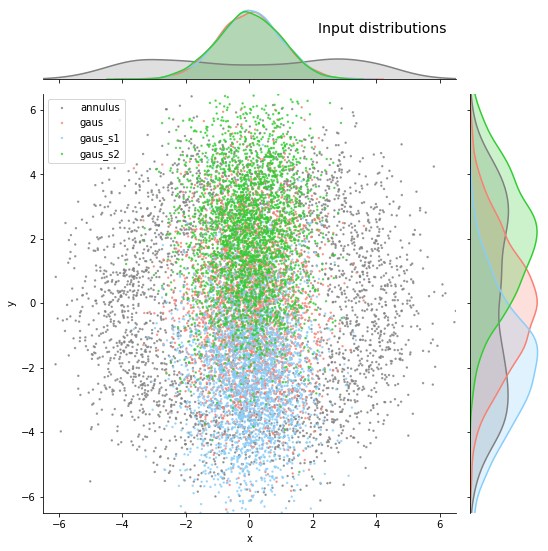

In [3]:
# create dataset
df = create_dataset(n_samples, features)

# inspect distributions
classes_to_show = ['gaus', 'annulus', 'gaus_s1', 'gaus_s2']
_, acc = plot_scatter(df, features, classes_to_show)
_.suptitle("Input distributions", 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path+'inspection.tiff', dpi = 500)

<div>
Our experiment will be subdivided in three steps:
</div>
    
<ul>
    <li> step 1: train the discriminant to distinguish between
    class 0, the nominal 2d normal, and class 1,
    the annulus, without including the systematic variations
    in the training. We'll see that the trained model will
    degrade in performances as soon as the systematic 
    variations will be considered in the evaluation.</li><br>
    <li> step 2: include the systematic variations in the training
    of the discriminant. In this case, class 0 will be composed 
    by a mixture of the 2d normal nominal sample and the 2 available 
    systematic samples. Now the performances will be slighlty worse 
    on the nominal 2d normal distribution, but overall better
    when the evaluation is performed on the systematic variations.</li><br>
    <li> step 3: use the adversarial neural network to penalise the 
    discriminant whenever it tries to learn features that depend
    on the systematic variations. In this last case, there is 
    a degradation in performance because we are forcing the 
    network to learn "less", but the performance will be 
    the same on the nominal and the systematic variations.
    Additionally the distribution of the output probability 
    of the discriminant will be very similar in the nominal
    and systematic cases: this means that the error associated
    to that specific systematic uncertainty is now reduced because
    the network won't perceive biases of that kind.</li>
</ul>

<h2>
    Definition of the Neural Network
</h2>

<div>
Two neural networks are defined:
</div>
    
<ul>
    <li> the discriminant D receives the x,y coordinates as input and
    returns the probability that a given point comes from one
    of the classes;</li><br>
    <li> the adversarial term A receives as input the probability from
    the discriminant and returns the softmax probability that
    the point comes from one of the systematics or the nominal
    sample.</li>
</ul>

In [4]:
# define discriminant
class dNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.out = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.out(dout)
        y = self.out_act(a2)
        return y

In [5]:
# adversarial part
class aNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.out = nn.Linear(50, 4)
        self.out_act = nn.Softmax(dim=1)

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.out(dout)
        y = self.out_act(a2)
        return y

<h3>
Training 1
</h3>
<div>
In this first scenario we train only the discriminant term
without including the systematic uncertainties. Consequently,
the result will behave nicely on the nominal 2d normal distribution
but the accuracy will drop as soon as the systematic variations
will be included. The distributions of the output value of the 
discriminant will also be very different for the nominal sample
and the systematic variations.
</div>

In [6]:
# prepare data
classes_to_exclude = ['gaus_s1', 'gaus_s2']
network_to_train = 'D'
df, datasetD = prepare_data(df, features, network_to_train, classes_to_exclude)

# initialise network
D = dNet()
# initialise optimiser
learning_rate_D = 0.001
optimiserD = optim.Adam(D.parameters(), lr=learning_rate_D)
# initialise loss function
criterionD = nn.BCELoss()

In [7]:
# training metrics
d_loss = []

# train a couple of epochs
n_epochs = 10
for e in tqdm(range(n_epochs)):

    # call training script
    metrics = train_epoch('D', df, features, datasetD,
                          D, optimiserD, criterionD,
                          None, None, None)

    # append metrics for plotting
    d_loss.extend(metrics[0])

100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


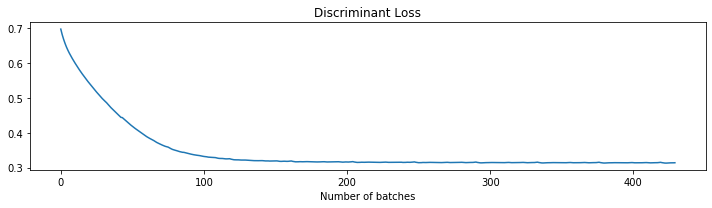

In [8]:
# plot losses
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.set_title('Discriminant Loss')
ax.set_xlabel('Number of batches')
ax.plot(d_loss)
plt.tight_layout()
plt.savefig(path + 'training1.tiff', dpi = 500)

In [9]:
# decision boundaries with no systs
_, acc = plot_scatter(df, features, ['gaus', 'annulus'], D)
_.suptitle("Boundaries (no systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries1.tiff', dpi = 500)
plt.close()

# decision boundaries with systs
_, acc = plot_scatter(df, features, 
                      ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], D)
_.suptitle("Boundaries (systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries1_fullsyst.tiff', dpi = 500)
plt.close()

# output distibutions
_ = plot_hist(df, ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], 'predictionD')
_.suptitle("Output distributions", 
           fontsize=14, x=0.58, y=0.67)
plt.savefig(path + 'ratio1.tiff', dpi = 500)
plt.close()

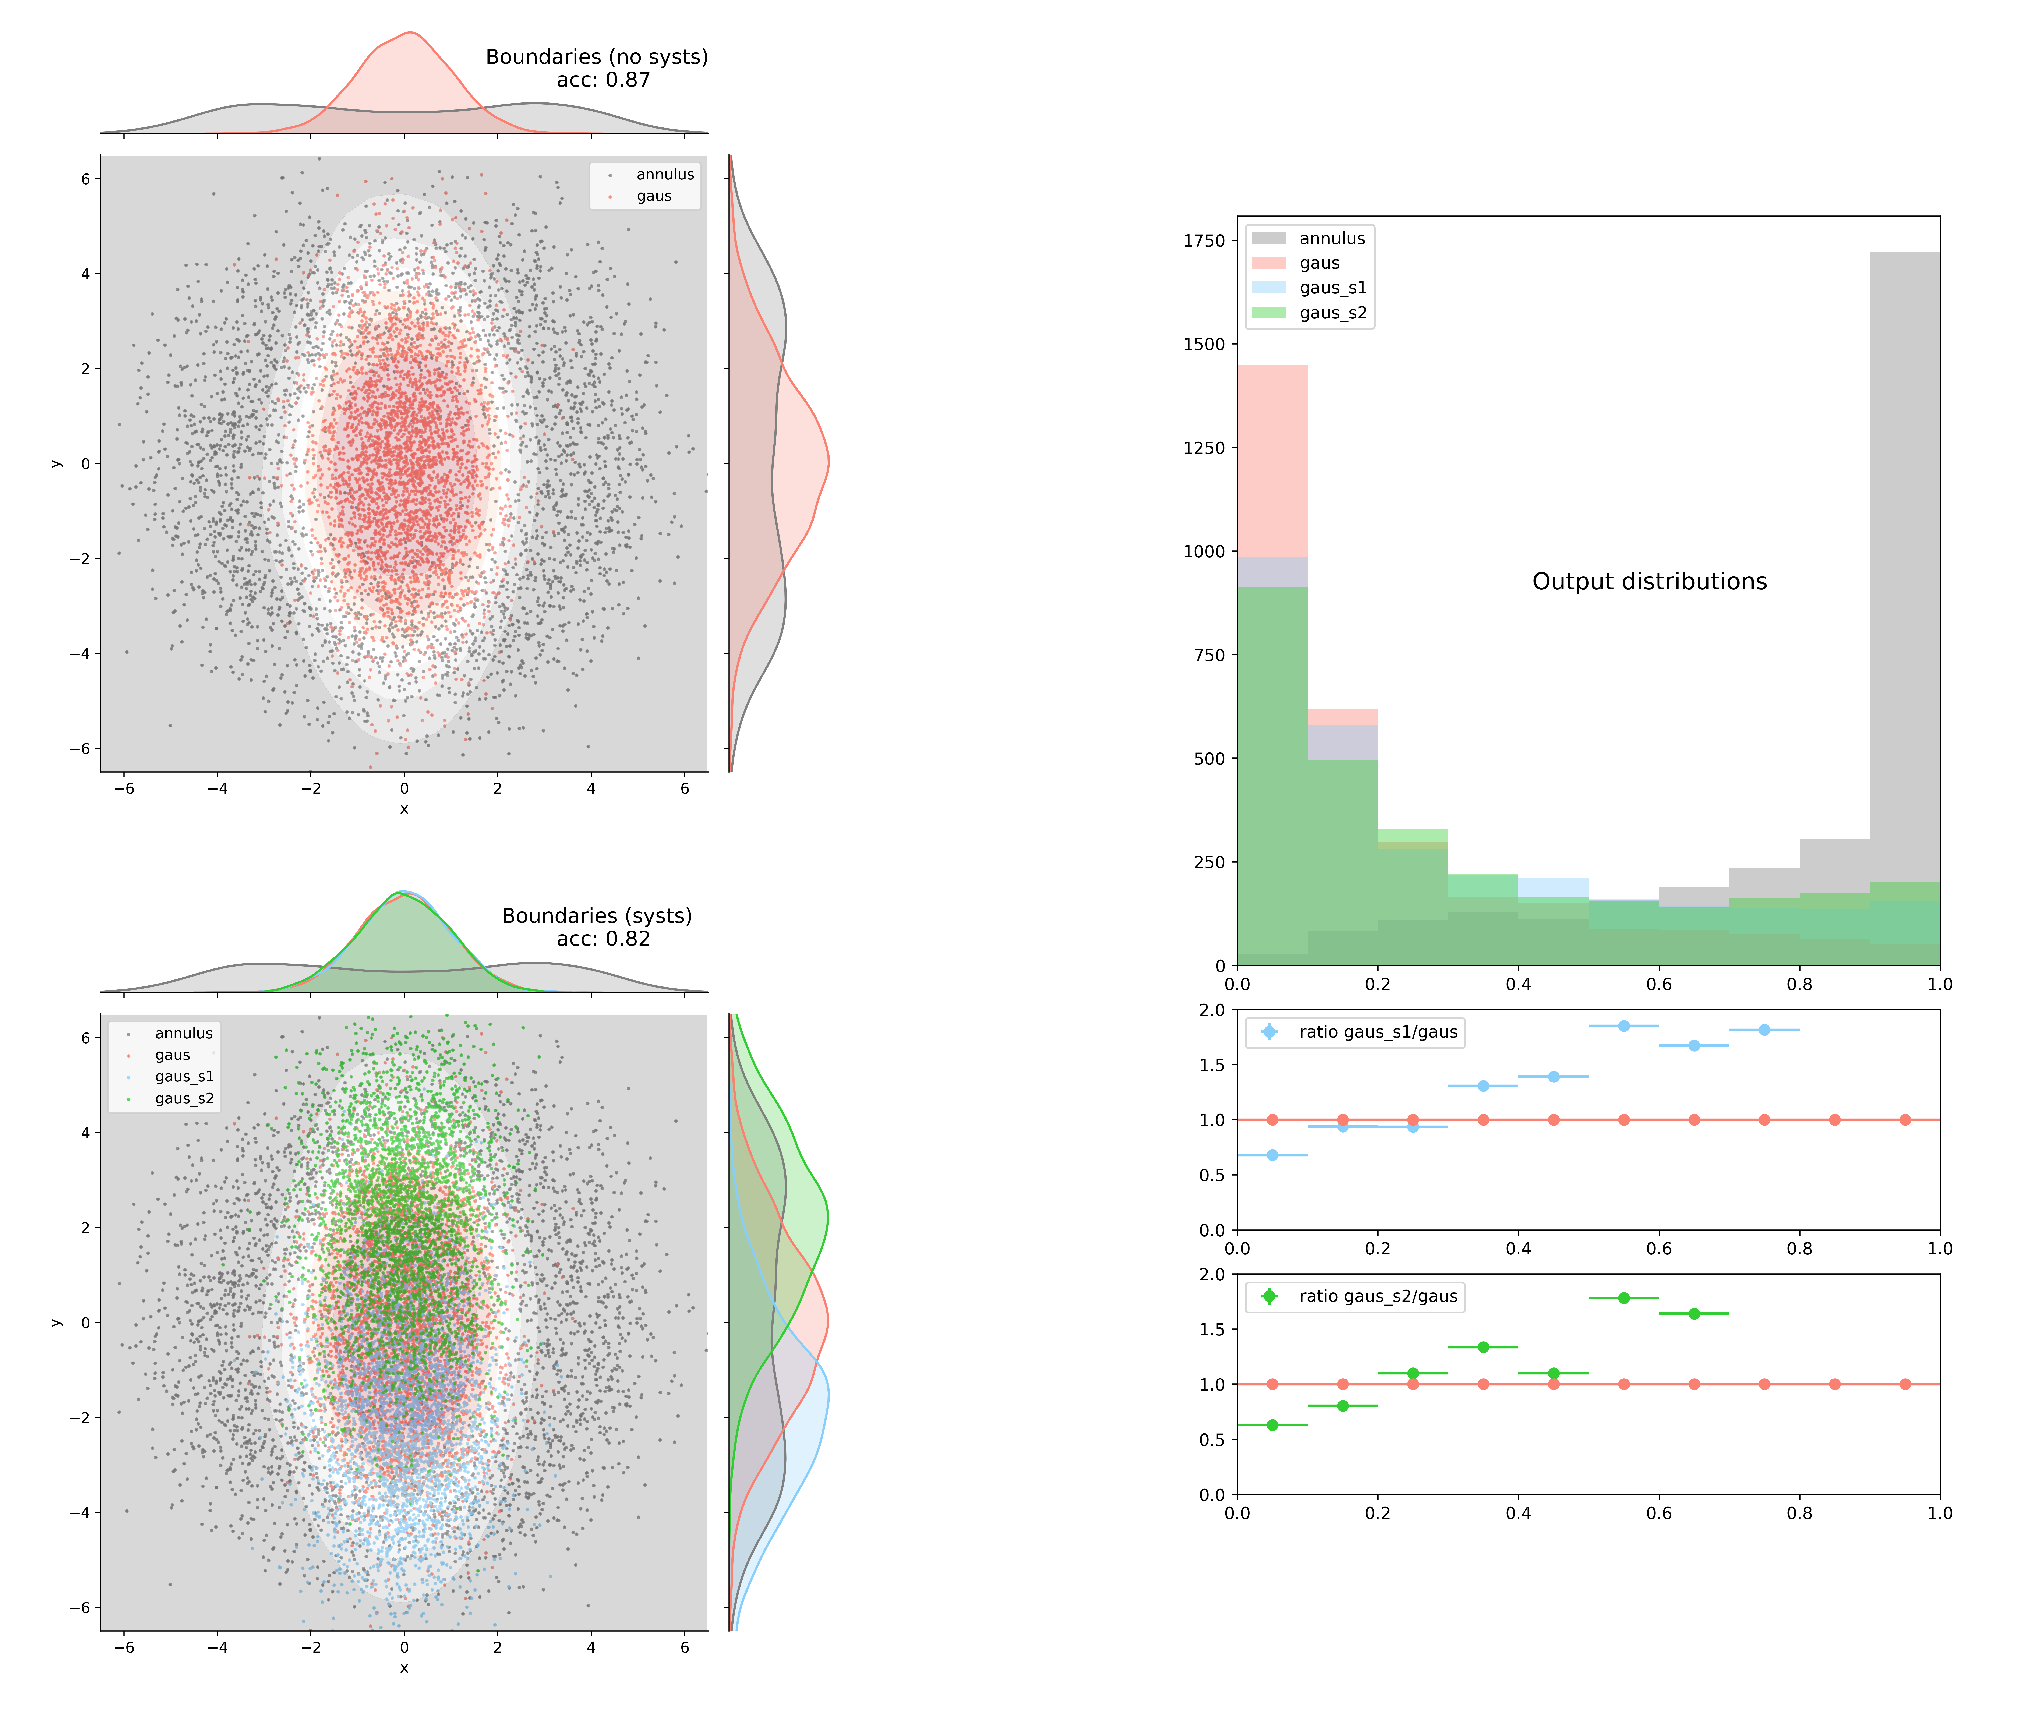

In [10]:
# plot everything together
fig=plt.figure(figsize=(32,24))
gs=GridSpec(4,5)

ax1=fig.add_subplot(gs[:2,:3])
ax1.axis('off')
image1=Image.open(path + 'boundaries1.tiff')
ax1.imshow(image1)
ax2=fig.add_subplot(gs[2:,:3])
ax2.axis('off')
image2=Image.open(path + 'boundaries1_fullsyst.tiff')
ax2.imshow(image2)
ax3=fig.add_subplot(gs[:,3:])
ax3.axis('off')
image3=Image.open(path + 'ratio1.tiff')
ax3.imshow(image3)
plt.tight_layout()

<h3>
Training 2
</h3>
<div>
A possible approach to mitigate the effect of the systematic uncertainties is
to include them in the training. Let's try. As you will see this is not enough.
The accuracy when evaluating with the systematic uncertainties will improve, but
the dependency of the output on the systematic uncertainty will still be 
present and the probability distribution of the neural network output for the 
nominal sample will still be different from the one of the systematic 
uncertainties.
</div>

In [11]:
# prepare data
classes_to_exclude = []
network_to_train = 'D'
df, datasetD = prepare_data(df, features, network_to_train, classes_to_exclude)

# initialise network
D = dNet()
# initialise optimiser
learning_rate_D = 0.001
optimiserD = optim.Adam(D.parameters(), lr=learning_rate_D)
# initialise loss function
criterionD = nn.BCELoss()

In [12]:
# training metrics
d_loss = []

# train a couple of epochs
n_epochs = 10
for e in tqdm(range(n_epochs)):

    # call training script
    metrics = train_epoch('D', df, features, datasetD,
                          D, optimiserD, criterionD,
                          None, None, None)

    # append metrics for plotting
    d_loss.extend(metrics[0])

100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


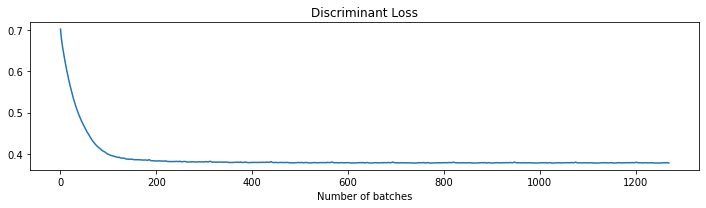

In [13]:
# plot losses
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.set_title('Discriminant Loss')
ax.set_xlabel('Number of batches')
ax.plot(d_loss)
plt.tight_layout()
plt.savefig(path + 'training2.tiff')

In [14]:
# decision boundaries with no systs
_, acc = plot_scatter(df, features, ['gaus', 'annulus'], D)
_.suptitle("Boundaries (no systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries2.tiff', dpi = 500)
plt.close()

# decision boundaries with systs
_, acc = plot_scatter(df, features, 
                      ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], D)
_.suptitle("Boundaries (systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries2_fullsyst.tiff', dpi = 500)
plt.close()

# output distibutions
_ = plot_hist(df, ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], 'predictionD')
_.suptitle("Output distributions", 
           fontsize=14, x=0.58, y=0.67)
plt.savefig(path + 'ratio2.tiff', dpi = 500)
plt.close()

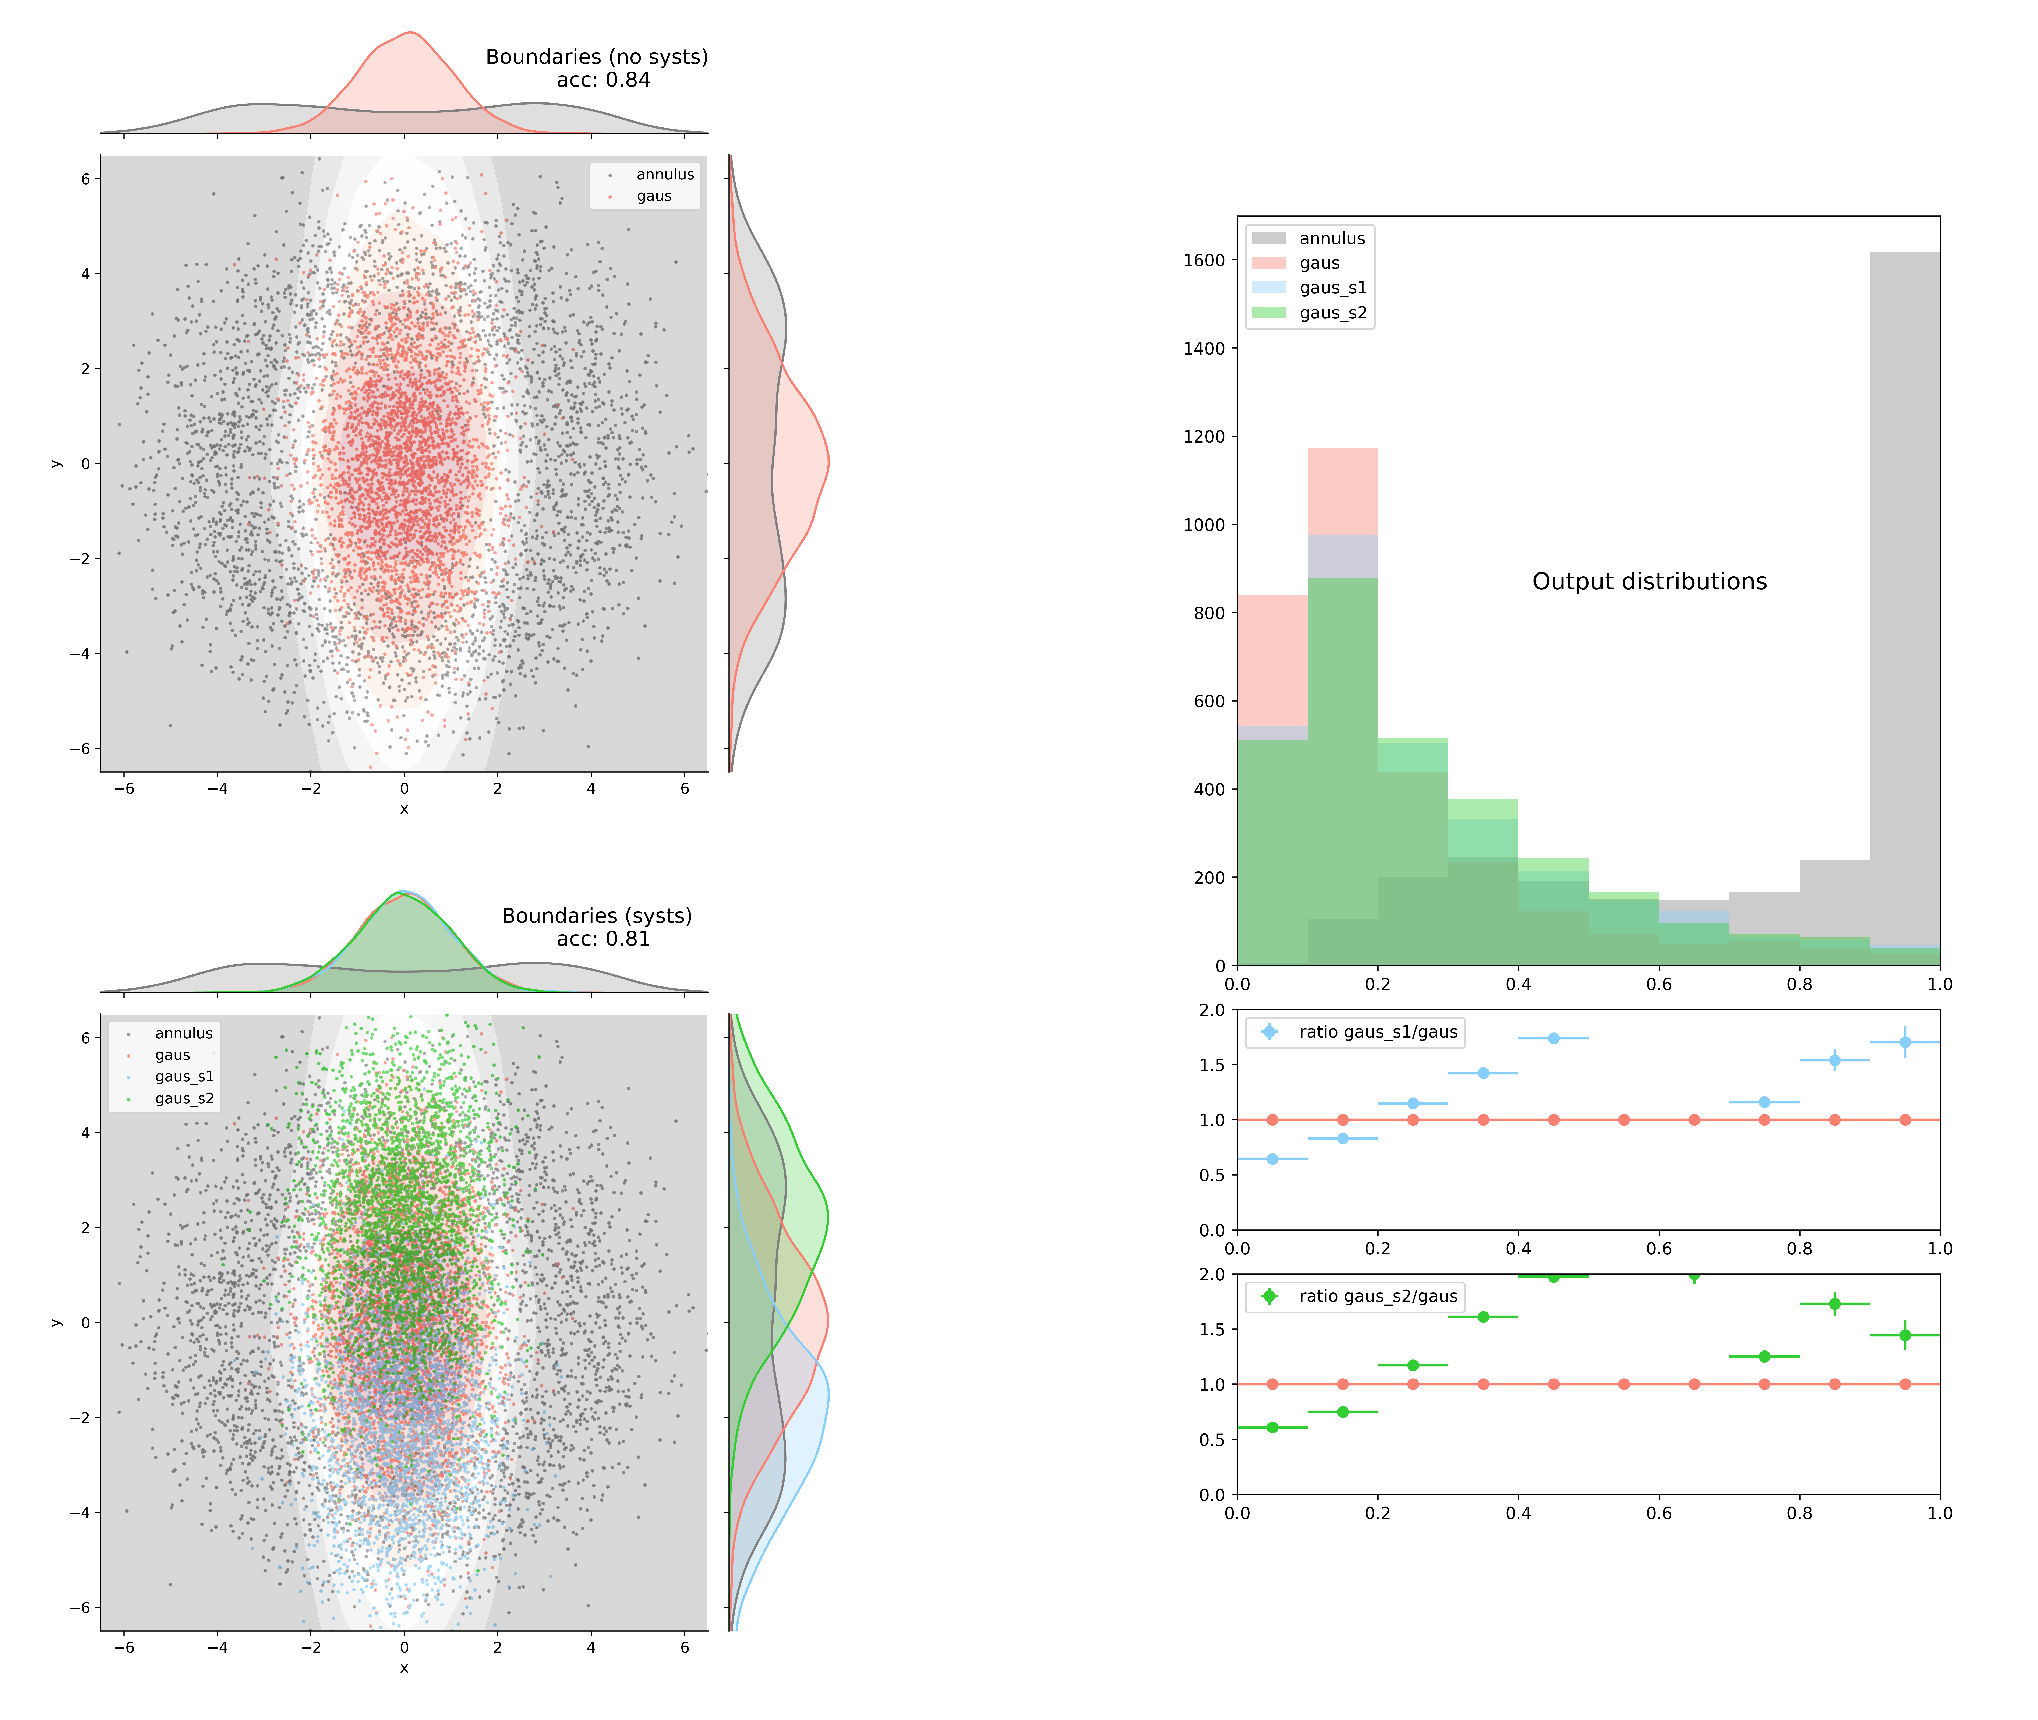

In [15]:
# plot everything together
fig=plt.figure(figsize=(32,24))
gs=GridSpec(4,5,wspace=None, hspace=None)

ax1=fig.add_subplot(gs[:2,:3])
ax1.axis('off')
image1=Image.open(path + 'boundaries2.tiff')
ax1.imshow(image1)
ax2=fig.add_subplot(gs[2:,:3])
ax2.axis('off')
image2=Image.open(path + 'boundaries2_fullsyst.tiff')
ax2.imshow(image2)
ax3=fig.add_subplot(gs[:,3:])
ax3.axis('off')
image3=Image.open(path + 'ratio2.tiff')
ax3.imshow(image3)
plt.tight_layout()

<h3>
Training 3
</h3>
<div>
Finally, let's use the adversarial network. In this case the adversarial term
will try to penalise configurations of the network that would distinguish btw
the nominal 2d normal distribution and the systematic variations. It works.
The y variable, which is the one affected by the systematic uncertainties,
is not used anymore to distinguish between classes. As a result, the distribution
of the output value of the discriminant is almost the same for the nominal 2d normal
and the systematic variations.
</div>

<h4>
Pretraining
</h4>

In [16]:
# prepare data
classes_to_exclude = []
network_to_train = 'D'
_, datasetD = prepare_data(df, features, network_to_train, classes_to_exclude)

classes_to_exclude = ['annulus']
network_to_train = 'A'
df, datasetA = prepare_data(df, features, network_to_train, classes_to_exclude)

# initialise network
D = dNet()
A = aNet()

# initialise optimiser
learning_rate_D = 0.001
optimiserD = optim.Adam(D.parameters(), lr=learning_rate_D)

learning_rate_A = 0.01
optimiserA = optim.SGD(A.parameters(), lr=learning_rate_A,
                       momentum=0.9, nesterov=True)

# initialise loss function
criterionD = nn.BCELoss()
criterionA = nn.NLLLoss()

In [17]:
# training metrics
d_loss, a_loss, c_loss = [], [], []

# pretraining D
n_epochs = 10
for e in tqdm(range(n_epochs)):

    # call training script
    metrics = train_epoch('D', df, features, datasetD,
                          D, optimiserD, criterionD,
                          A, optimiserA, criterionA)

    # append metrics for plotting
    d_loss.extend(metrics[0])

# pretraining A
n_epochs = 4
for e in tqdm(range(n_epochs)):

    # call training script
    metrics = train_epoch('A', df, features, datasetA,
                          D, optimiserD, criterionD, 
                          A, optimiserA, criterionA)

    # append metrics for plotting
    a_loss.extend(metrics[1])

100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


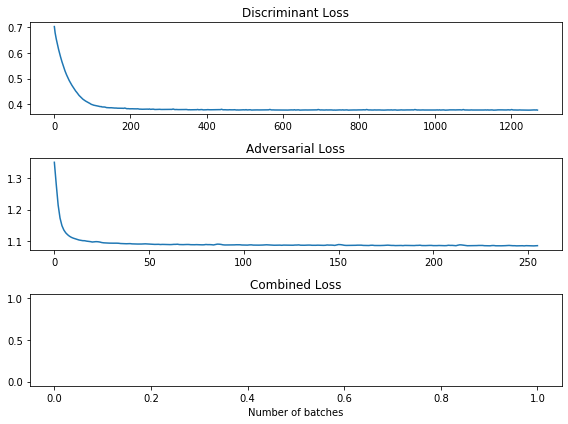

In [18]:
# plot losses
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].set_title('Discriminant Loss')
ax[1].set_title('Adversarial Loss')
ax[2].set_title('Combined Loss')
ax[2].set_xlabel('Number of batches')
ax[0].plot(d_loss)
ax[1].plot(a_loss)
ax[2].plot(c_loss)
plt.tight_layout()
plt.savefig(path + 'pretraining3.tiff')

In [19]:
# decision boundaries with no systs
_, acc = plot_scatter(df, features, ['gaus', 'annulus'], D)
_.suptitle("Boundaries (no systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries3_pretraining.tiff', dpi = 500)
plt.close()

# decision boundaries with systs
_, acc = plot_scatter(df, features, 
                      ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], D)
_.suptitle("Boundaries (systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries3_fullsyst_pretraining.tiff', dpi = 500)
plt.close()

# output distibutions
_ = plot_hist(df, ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], 'predictionD')
_.suptitle("Output distributions", 
           fontsize=14, x=0.58, y=0.67)
plt.savefig(path + 'ratio3_pretraining.tiff', dpi = 500)
plt.close()

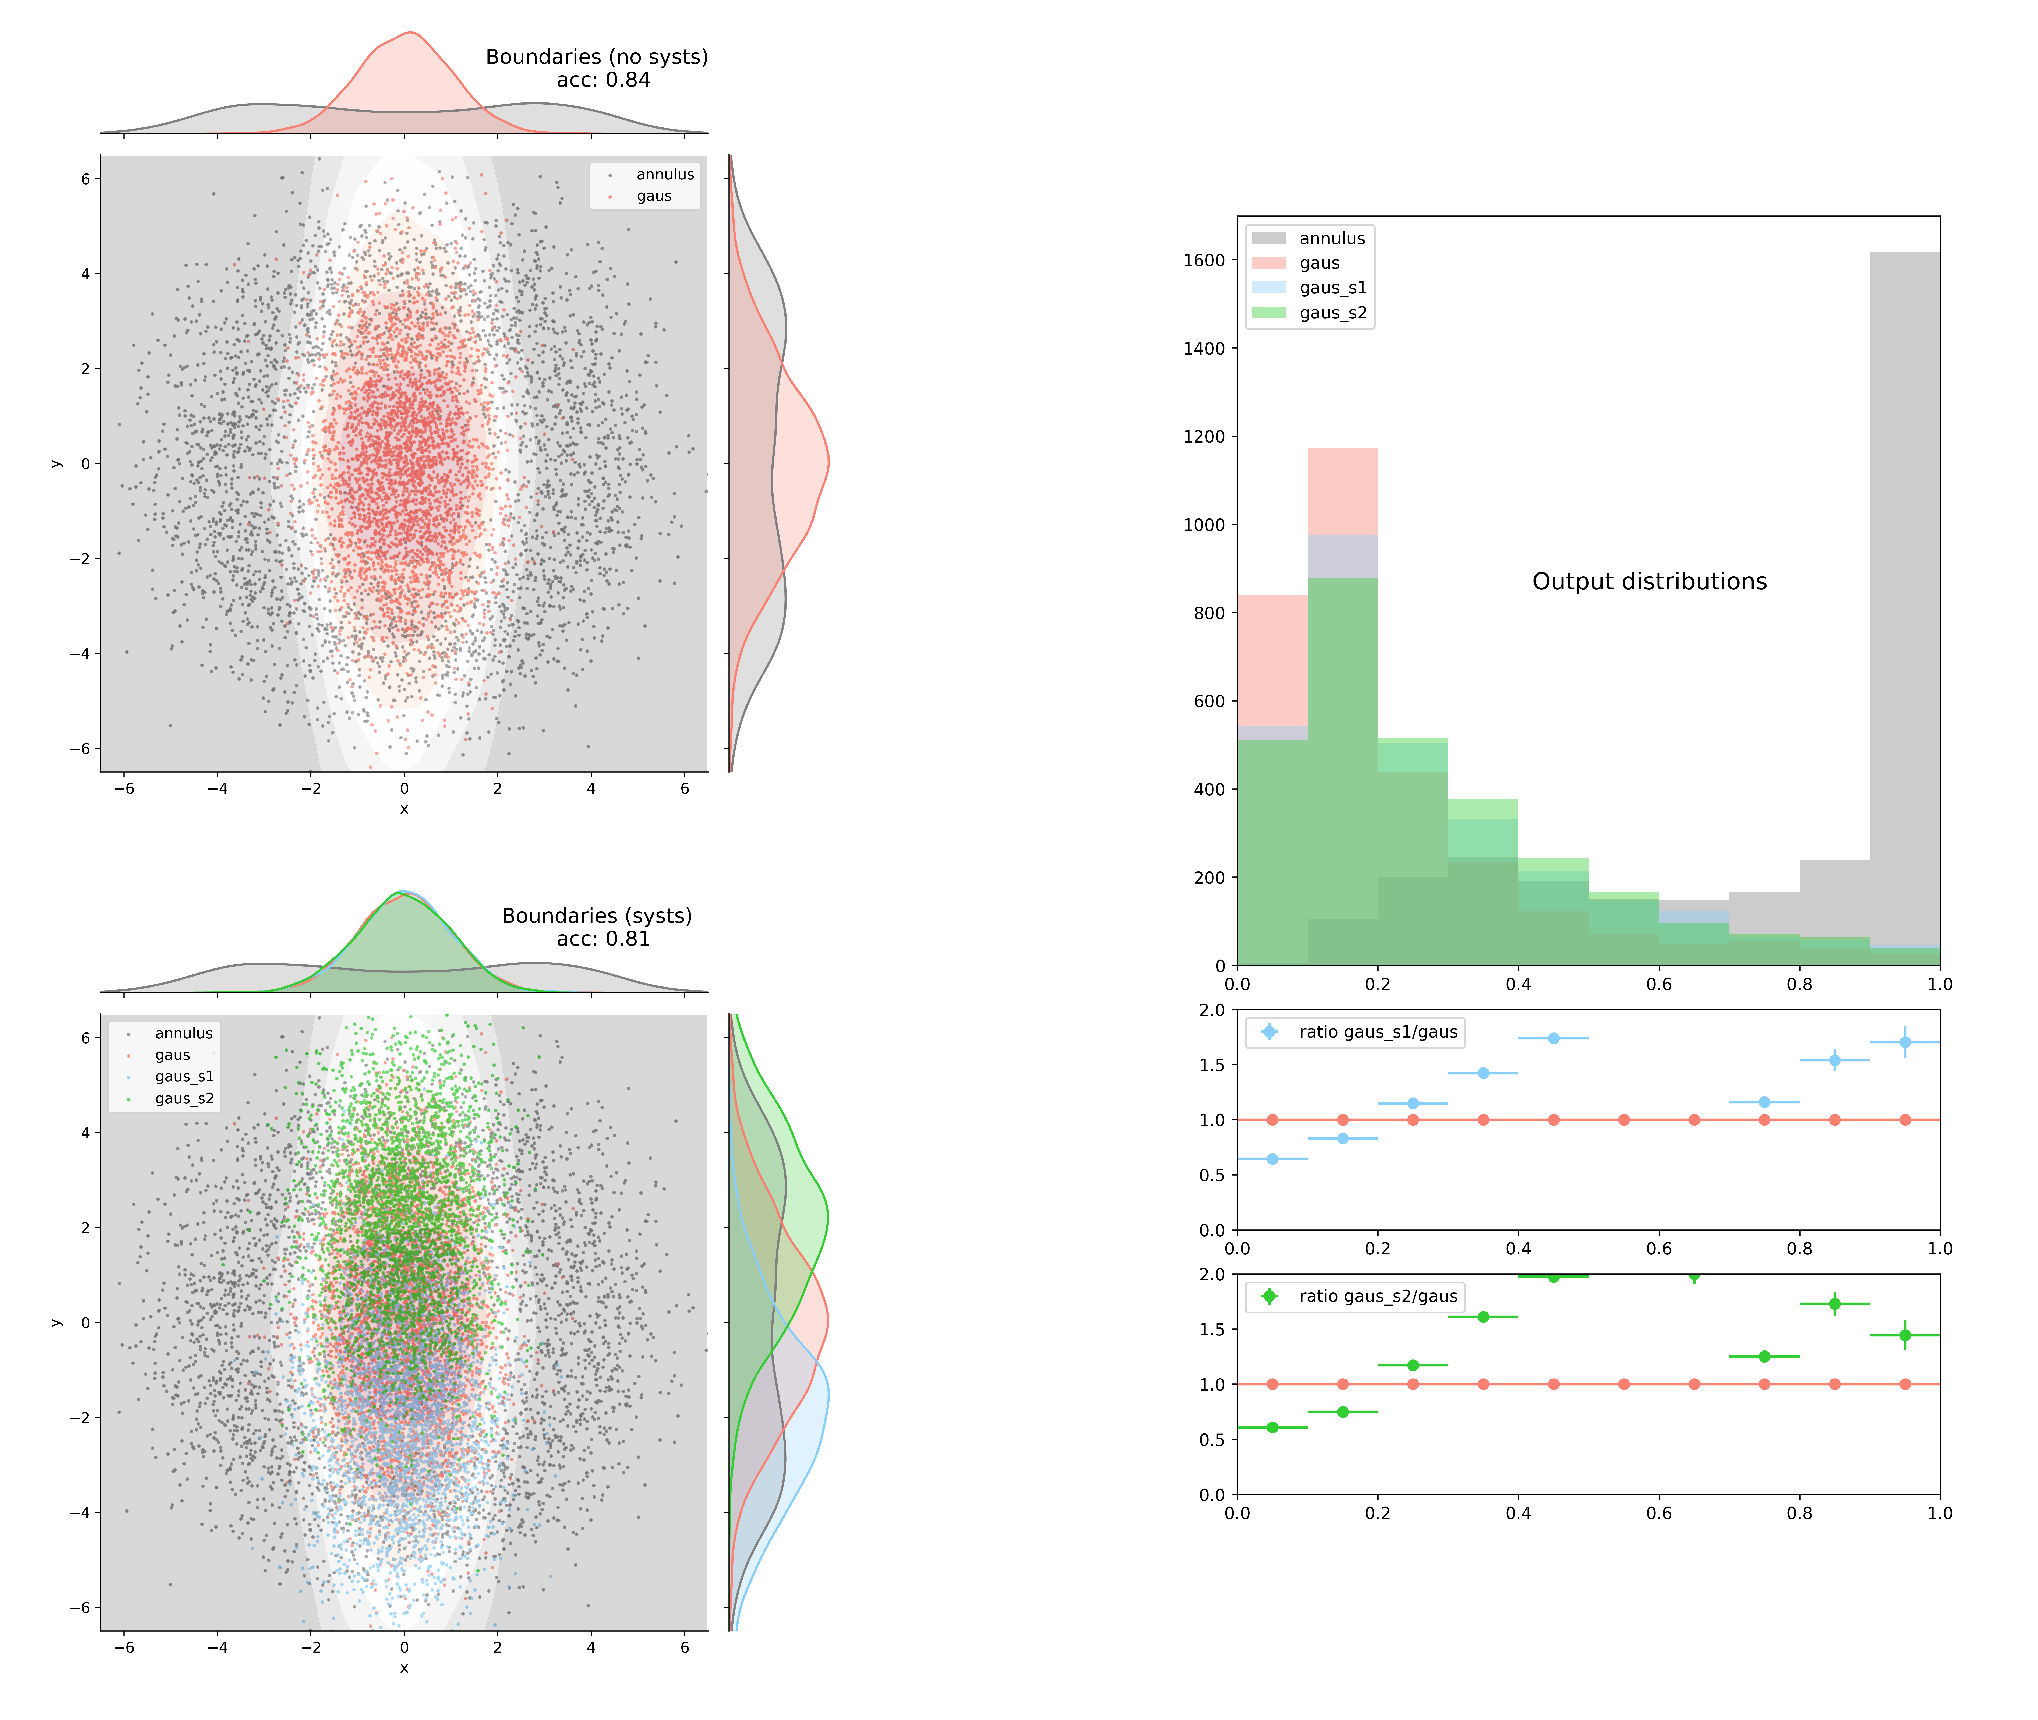

In [20]:
# plot everything together
fig=plt.figure(figsize=(32,24))
gs=GridSpec(4,5,wspace=None, hspace=None)

ax1=fig.add_subplot(gs[:2,:3])
ax1.axis('off')
image1=Image.open(path + 'boundaries3_pretraining.tiff')
ax1.imshow(image1)
ax2=fig.add_subplot(gs[2:,:3])
ax2.axis('off')
image2=Image.open(path + 'boundaries3_fullsyst_pretraining.tiff')
ax2.imshow(image2)
ax3=fig.add_subplot(gs[:,3:])
ax3.axis('off')
image3=Image.open(path + 'ratio3_pretraining.tiff')
ax3.imshow(image3)
plt.tight_layout()

<h4>
Training
</h4>

In [21]:
# training metrics
d_loss, a_loss, c_loss = [], [], []

n_epochs = 200
adv_penalty = 70.0
for e in tqdm(range(n_epochs)):

    # call training script
    metrics = train_epoch('both', df, features, datasetD,
                          D, optimiserD, criterionD, 
                          A, optimiserA, criterionA, 
                          adv_penalty, True)

    # call training script
    _______ = train_epoch('A', df, features, datasetA,
                          D, optimiserD, criterionD, 
                          A, optimiserA, criterionA)

    # reduce learning rate with time
    adjust_learning_rate(optimiserD, e)
    adjust_learning_rate(optimiserA, e)

    # append metrics for plotting
    d_loss.extend(metrics[0])
    a_loss.extend(metrics[1])
    c_loss.extend(metrics[2])

100%|██████████| 200/200 [04:41<00:00,  1.41s/it]


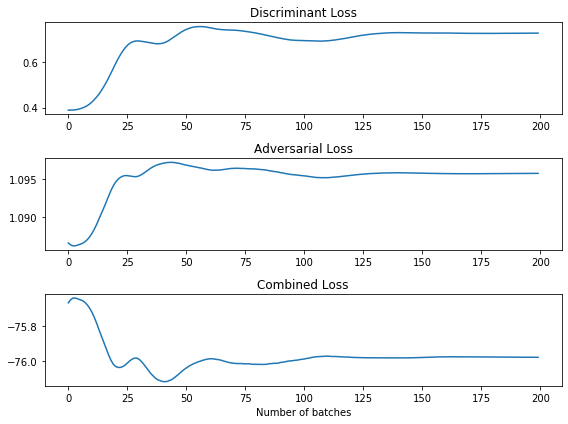

In [22]:
# plot losses
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].set_title('Discriminant Loss')
ax[1].set_title('Adversarial Loss')
ax[2].set_title('Combined Loss')
ax[2].set_xlabel('Number of batches')
ax[0].plot(d_loss)
ax[1].plot(a_loss)
ax[2].plot(c_loss)
plt.tight_layout()
plt.savefig(path + 'training3.tiff')

In [23]:
# decision boundaries with no systs
_, acc = plot_scatter(df, features, ['gaus', 'annulus'], D)
_.suptitle("Boundaries (no systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries3.tiff', dpi = 500)
plt.close()

# decision boundaries with systs
_, acc = plot_scatter(df, features, 
                      ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], D)
_.suptitle("Boundaries (systs) \n acc: " + str(round(acc, 2)), 
           fontsize=14, x=0.7, y=0.95)
plt.savefig(path + 'boundaries3_fullsyst.tiff', dpi = 500)
plt.close()

# output distibutions
_ = plot_hist(df, ['gaus', 'annulus', 'gaus_s1', 'gaus_s2'], 'predictionD')
_.suptitle("Output distributions", 
           fontsize=14, x=0.58, y=0.67)
plt.savefig(path + 'ratio3.tiff', dpi = 500)
plt.close()

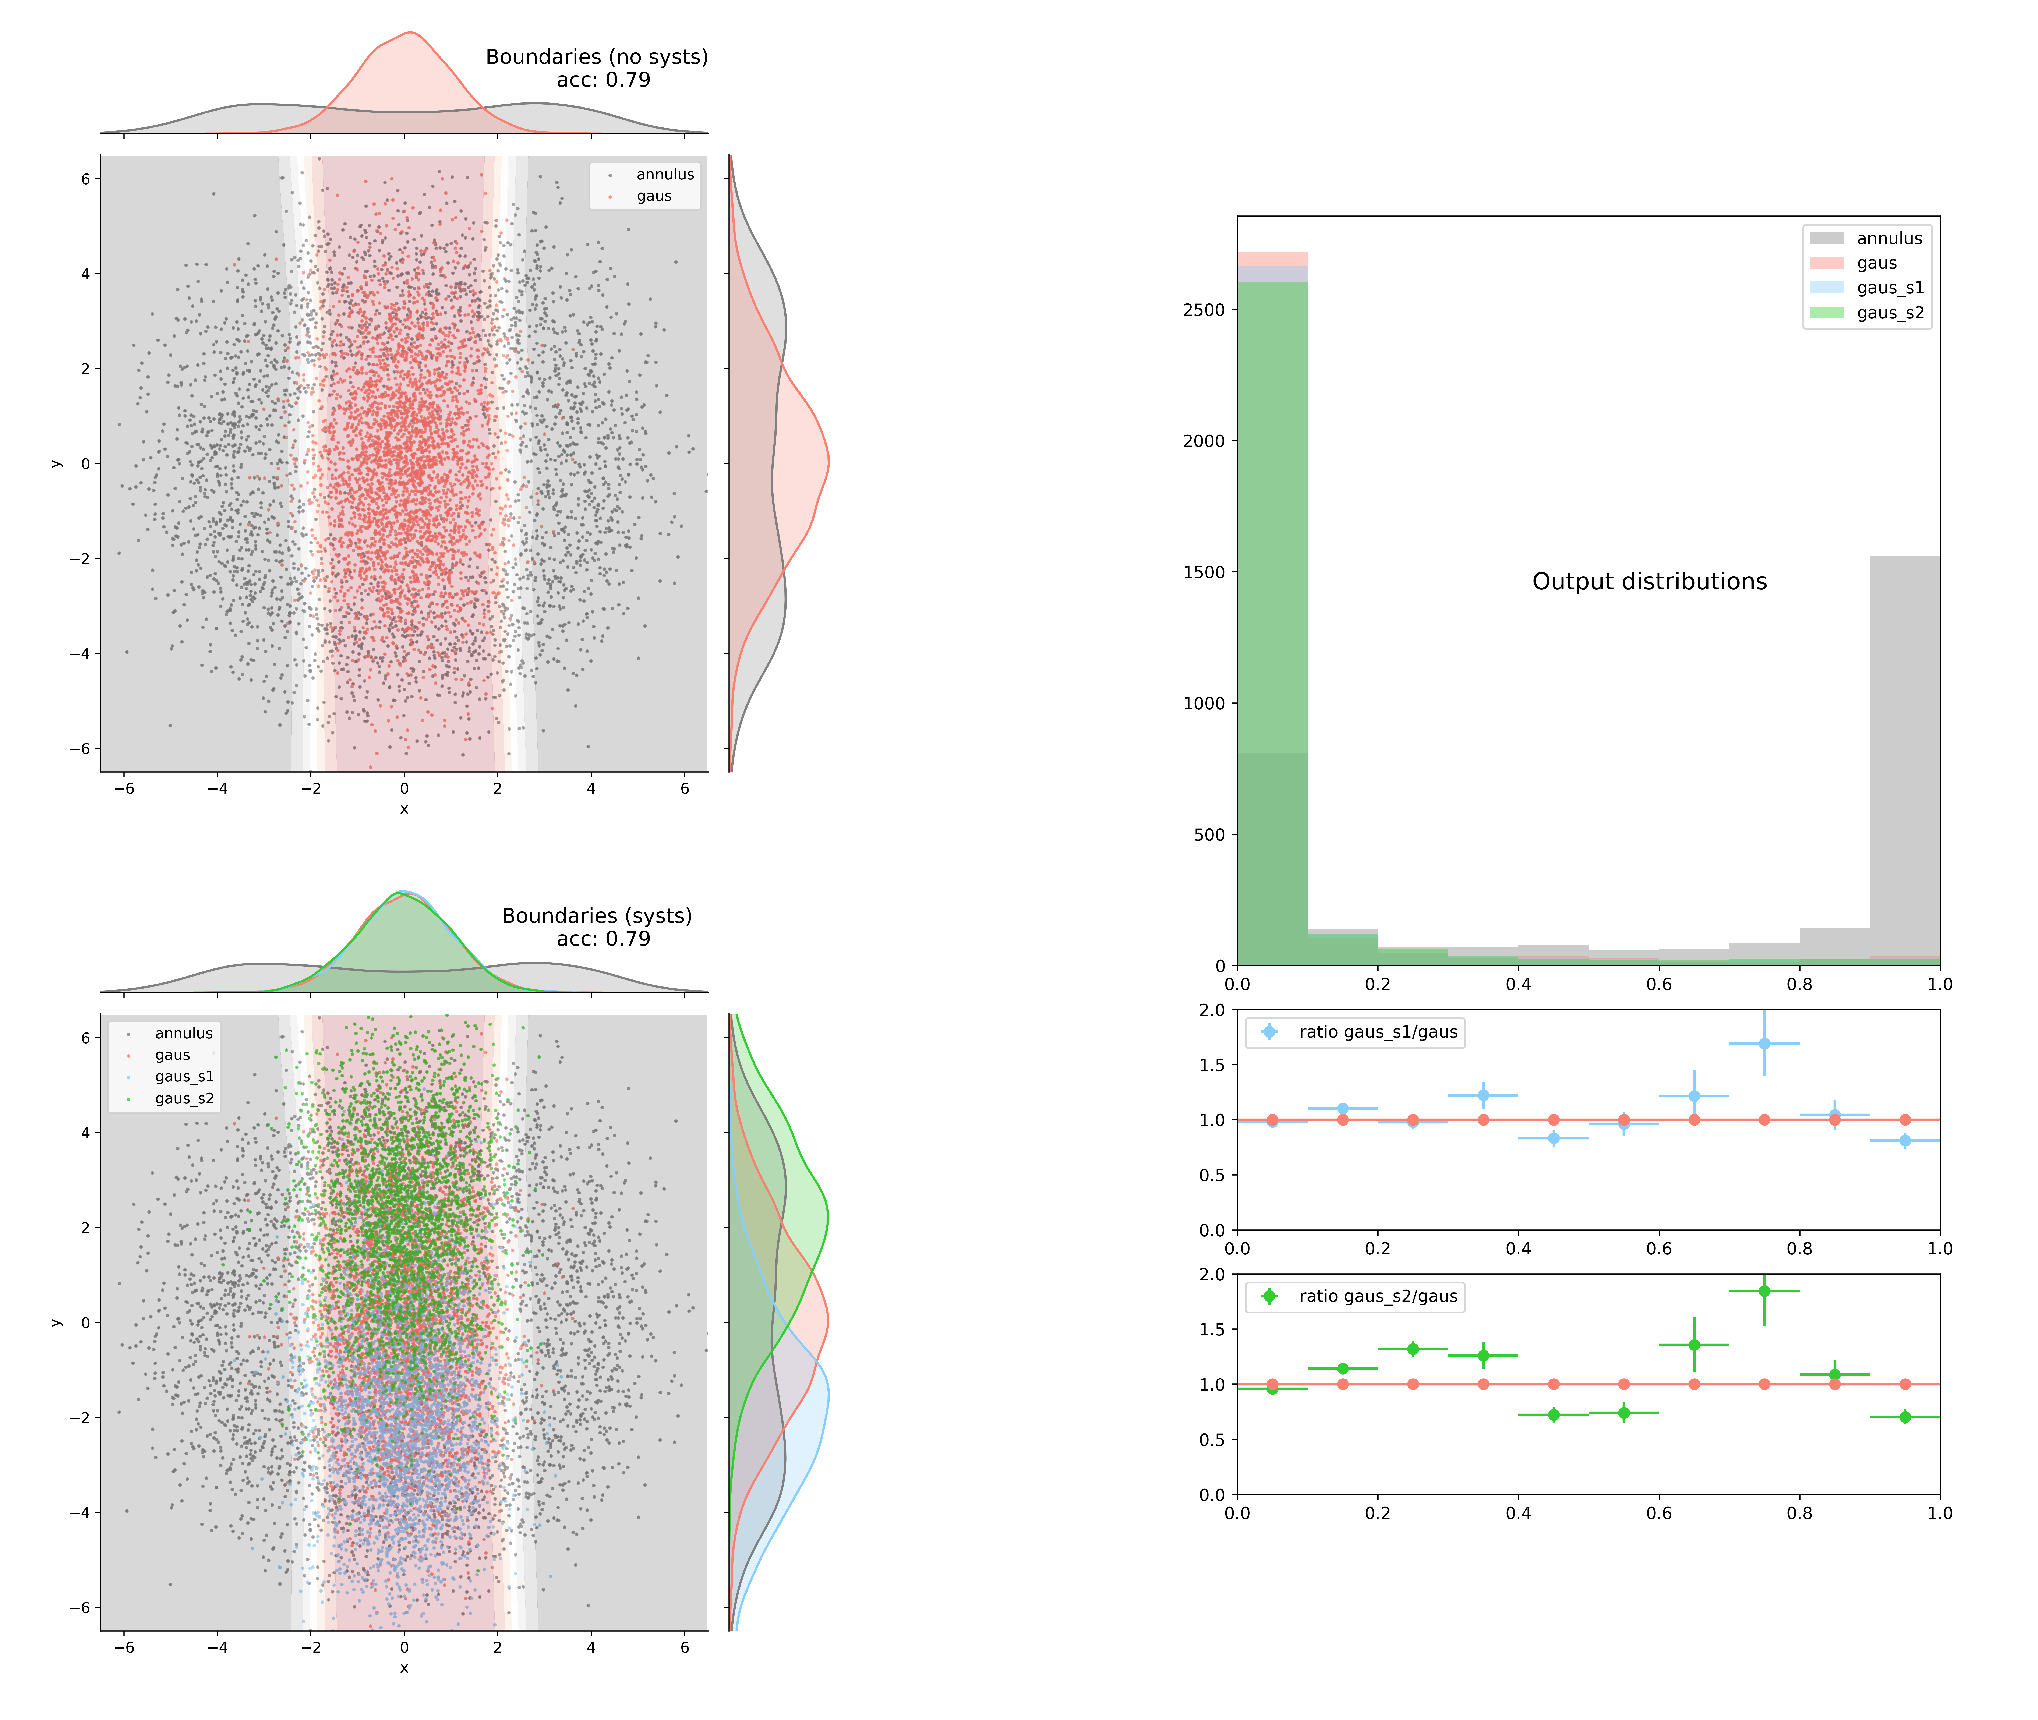

In [24]:
# plot everything together
fig=plt.figure(figsize=(32,24))
gs=GridSpec(4,5,wspace=None, hspace=None)

ax1=fig.add_subplot(gs[:2,:3])
ax1.axis('off')
image1=Image.open(path + 'boundaries3.tiff')
ax1.imshow(image1)
ax2=fig.add_subplot(gs[2:,:3])
ax2.axis('off')
image2=Image.open(path + 'boundaries3_fullsyst.tiff')
ax2.imshow(image2)
ax3=fig.add_subplot(gs[:,3:])
ax3.axis('off')
image3=Image.open(path + 'ratio3.tiff')
ax3.imshow(image3)
plt.tight_layout()

<h2>
    Conclusions
</h2>

<div>
As promised, it has been shown that the usage of adversarial networks can decrease the impact of the systematic uncertainties on a measurement. It has to be noted that training such models is very complicated and requires a lot of fine tuning to avoid imbalanced learning-paces between the two components (discriminant and adversarial), that would make it impossible to achieve the desired result.
</div>
<br>
Questions?

![title](images/smile.jpg)